In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib  inline
plt.style.use('seaborn-darkgrid')
sns.set(style = 'darkgrid')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb  
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import KFold
import xgboost as xgb 
from catboost import CatBoostRegressor
import time 

In [189]:
label = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件1-区域15分钟负荷数据.csv")
industry = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件2-行业日负荷数据.csv")
weather = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件3-气象数据.csv")

In [190]:
weather = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件3-气象数据.csv")
weather['最高温度'] = weather['最高温度'].map(lambda d: d.replace('℃','')).astype(int)
weather['最低温度'] = weather['最低温度'].map(lambda d: d.replace('℃','')).astype(int)
weather['start_weather'] = weather['天气状况'].apply(lambda x: x.split('/')[0])
weather['end_weather'] = weather['天气状况'].apply(lambda x: x.split('/')[1])

dic1 = {'晴':0,'晴间多云':1, '多云':2, '局部多云':2,'阴':3 ,'雾':4, '小雨':5, '小到中雨':6, '小雨-中雨':6, '中雨':7, '阵雨':8,
 '中雨-大雨':9, '中到大雨':9, '大雨':10,'雷阵雨':11, '大到暴雨':12, '暴雨':13}
dic2 = {'无持续风向<3级':3, '北风4～5级':6, '微风<3级':3, '北风3':4, '东北风3～4级':5, '北风3～4级':5,
       '南风3～4级':5, '南风4～5级':6, '东北偏东风2':2, '无持续风向微风':0, '无持续风向1-2级':1, '东风3-4级':5,
       '东南风4-5级':6, '东风3～4级':5, '东北风3-4级':5, '东风8-9级':7, '东南风3-4级':5, '北风3-4级':5,
       '北风4-5级':6, '南风3-4级':5, '南风1-2级':1, '东南风1-2级':1, '西南风3-4级':5, '东风1-2级':1,
       '北风1-2级':1, '东北风1-2级':1, '西南风1-2级':1}
dic3 = {'无持续风向<3级':3, '北风4～5级':6, '北风3～4级':5, '微风<3级':3, '北风3':4, '东北偏东风2':2,
       '无持续风向微风':0, '无持续风向1-2级':1, '东风3-4级':5, '东南风4-5级':6, '东南风3～4级':5, '东北风3-4级':5,
       '东风8-9级':7, '东南风3-4级':5, '北风3-4级':5, '北风4-5级':6, '南风3-4级':5, '南风1-2级':1,
       '东南风1-2级':1, '西南风3-4级':5, '东风1-2级':1, '北风1-2级':1, '东北风1-2级':1, '西南风1-2级':1}

weather['start_weather']=weather['start_weather'].map(dic1)
weather['end_weather']=weather['end_weather'].map(dic1)
weather['白天风力风向']=weather['白天风力风向'].map(dic2)
weather['夜晚风力风向']=weather['夜晚风力风向'].map(dic3)

In [191]:
weather = weather.drop_duplicates(['日期'])

In [192]:
weather['温差'] = weather['最高温度']-weather['最低温度']

In [193]:
weather['温差'] = weather['最高温度']-weather['最低温度']

In [194]:
weather['天气变化'] = weather['start_weather']-weather['end_weather']

In [195]:
label = label.rename(columns={'数据时间':'日期1'})
label['日期'] = label['日期1'].apply(lambda x: x.split(' ')[0])
weather.loc[:, '日期'] = pd.to_datetime(weather.loc[:, '日期'], format='%Y年%m月%d日', errors='coerce')
label.loc[:, '日期'] = pd.to_datetime(label.loc[:, '日期'], format='%Y/%m/%d', errors='coerce')

In [196]:
train = label.merge(weather,on='日期',how='left')

In [197]:
train['日期1'] = pd.to_datetime(train['日期1'])

In [198]:
train0 = train.rename(columns = {'日期1':'create_time'})

In [199]:
train0['月'] = train0['create_time'].dt.month 
train0['天'] = train0['create_time'].dt.day
train0['小时'] = train0['create_time'].dt.hour
train0['一年第几天'] = train0['create_time'].dt.dayofyear
train0['一年第几周'] = train0['create_time'].dt.week
train0['分'] = train0['create_time'].dt.minute 
# test0['月'] = test0['create_time'].dt.month 
# test0['天'] = test0['create_time'].dt.day
# test0['小时'] = test0['create_time'].dt.hour
# test0['一年第几天'] = test0['create_time'].dt.dayofyear
# test0['一年第几周'] = test0['create_time'].dt.week
# test0['分'] = test0['create_time'].dt.minute      
period_dict ={
            23: '深夜', 0: '深夜', 1: '深夜',
            2: '凌晨', 3: '凌晨', 4: '凌晨',
            5: '早晨', 6: '早晨', 7: '早晨',
            8: '上午', 9: '上午', 10: '上午', 11: '上午',
            12: '中午', 13: '中午',
            14: '下午', 15: '下午', 16: '下午', 17: '下午',
            18: '傍晚',
            19: '晚上', 20: '晚上', 21: '晚上', 22: '晚上',
            }
train0['时间段']=train0['小时'].map(period_dict)
dict1 = {'深夜':1, '凌晨':2, '早晨':3, '上午':4, '中午':5, '下午':6, '傍晚':7, '晚上':8}
train0['时间段'] = train0['时间段'].map(dict1)
            
# test0['时间段']=test0['小时'].map(period_dict)
        
# test0['时间段'] = test0['时间段'].map(dict1)
# 一年中的哪个季度
season_dict = {
                1: '春季', 2: '春季', 3: '春季',
                4: '夏季', 5: '夏季', 6: '夏季',
                7: '秋季', 8: '秋季', 9: '秋季',
                10: '冬季', 11: '冬季', 12: '冬季',
            }
train0['季节']=train0['月'].map(season_dict)
dict = {'春季':1,'夏季':2,'秋季':3,'冬季':4}
train0['季节'] = train0['季节'].map(dict)
# test0['季节']=test0['月'].map(season_dict)
# test0['季节'] = test0['季节'].map(dict)
            
train0['是否月初'] = train0['create_time'].apply(lambda x: x.is_month_start)
# 是否月末
train0['是否月末'] = train0['create_time'].apply(lambda x: x.is_month_end)
# 是否季节初
train0['是否季节初'] = train0['create_time'].apply(lambda x: x.is_quarter_start)
# 是否季节末
train0['是否季节末'] = train0['create_time'].apply(lambda x: x.is_quarter_end)
train0['是否周末'] = train0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

# test0['是否月初'] = test0['create_time'].apply(lambda x: x.is_month_start)
#                 # 是否月末
# test0['是否月末'] = test0['create_time'].apply(lambda x: x.is_month_end)
#                 # 是否季节初
# test0['是否季节初'] = test0['create_time'].apply(lambda x: x.is_quarter_start)
#                 # 是否季节末
# test0['是否季节末'] = test0['create_time'].apply(lambda x: x.is_quarter_end)
# test0['是否周末'] = test0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

train0['是否月末'] = [int(i) for i in train0['是否月末']]
train0['是否季节初'] = [int(i) for i in train0['是否季节初']]
train0['是否季节末'] = [int(i) for i in train0['是否季节末']]
train0['是否周末'] = [int(i) for i in train0['是否周末']]
train0['是否月初'] = [int(i) for i in train0['是否月初']]

#test0['是否月末'] = [int(i) for i in test0['是否月末']]
#test0['是否季节初'] = [int(i) for i in test0['是否季节初']]
#test0['是否季节末'] = [int(i) for i in test0['是否季节末']]
# test0['是否周末'] = [int(i) for i in test0['是否周末']]
#test0['是否月初'] = [int(i) for i in test0['是否月初']]

In [200]:
del train0['天气状况']

In [201]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128156 entries, 0 to 128155
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   create_time    128156 non-null  datetime64[ns]
 1   总有功功率（kw）      128156 non-null  float64       
 2   日期             128156 non-null  datetime64[ns]
 3   最高温度           128156 non-null  int32         
 4   最低温度           128156 non-null  int32         
 5   白天风力风向         128156 non-null  int64         
 6   夜晚风力风向         128156 non-null  int64         
 7   start_weather  128156 non-null  int64         
 8   end_weather    128156 non-null  int64         
 9   温差             128156 non-null  int32         
 10  天气变化           128156 non-null  int64         
 11  月              128156 non-null  int64         
 12  天              128156 non-null  int64         
 13  小时             128156 non-null  int64         
 14  一年第几天          128156 non-null  int64         
 15  

# 数据选取

# 数据归一化

In [202]:
train0['总有功功率（kw）'] = (train0['总有功功率（kw）']-train0['总有功功率（kw）'].min())/(train0['总有功功率（kw）'].max()-train0['总有功功率（kw）'].min())

In [203]:
train0 = train0.fillna(train0.mean())

In [204]:
a = 18960

In [205]:
b10 = 960

In [206]:
b91 = 91*96

MSE: 0.00015017357118083776
RMSE: 0.012254532679006482
MAE: 0.009244725602255085
MAPE: 0.015125210211104318
R方: 0.9680231825126354


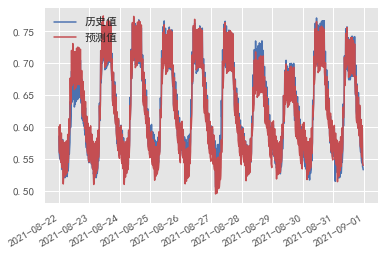

In [218]:
train1 = train0[len(train0)-a:len(train0)-b10][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y = train0[len(train0)-a:len(train0)-b10]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b10:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y_test1 = train0[len(train0)-b10:]['总有功功率（kw）']
model_lgb = lgb.LGBMRegressor(
                learning_rate=0.01,
                max_depth=6,
                n_estimators=2500,
                    boosting_type='gbdt',
                    random_state=2021,
                    objective='regression',
                    num_leaves = '36',#256  #'32'线上4.10
                    verbose=-1)
lgb_model = model_lgb.fit(x_train1,y)
pred_test1 = model_lgb.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test1)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-960:]['create_time'], train0[len(train0)-960:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-960:]['create_time'],pred_test1 , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\lgb未来十天.jpg',dpi=400)
plt.show()

In [118]:
a = 100000

In [219]:
train1 = train0[len(train0)-a:len(train0)-b10][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y = train0[len(train0)-a:len(train0)-b10]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b10:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y_test1 = train0[len(train0)-b10:]['总有功功率（kw）']
catboost_model = CatBoostRegressor(
                            iterations=3500, learning_rate=0.01, depth=8,random_seed=2021,verbose = False
                                                        )


catboost_model2=catboost_model.fit(x_train1,y,verbose = False)

pred_test2 = catboost_model.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test2)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-960:]['create_time'], train0[len(train0)-960:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-960:]['create_time'],pred_test2 , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\cat未来十天.jpg',dpi=400)
plt.show()

MSE: 0.00014130304742568562
RMSE: 0.011887095836481072
MAE: 0.009009248273799378
MAPE: 0.014643867576813524
R方: 0.9699120043399746


In [120]:
a=90000

In [220]:
train1 = train0[len(train0)-a:len(train0)-b10][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y = train0[len(train0)-a:len(train0)-b10]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b10:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y_test1 = train0[len(train0)-b10:]['总有功功率（kw）']
xgb_model = xgb.XGBRegressor(
     objective='reg:squarederror',n_jobs=-1,n_estimators=1000,max_depth=7
                                            ,subsample=0.8,learning_rate= 0.08,gamma=0,colsample_bytree=0.9,
                                             random_state=10, max_features=None, alpha=0.9)
xgbboost_model1=xgb_model.fit(x_train1,y)
pred_test3 = xgb_model.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test3)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-960:]['create_time'], train0[len(train0)-960:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-960:]['create_time'],pred_test3 , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\xgb未来十天.jpg',dpi=400)
plt.show()

MSE: 0.00015549062022687094
RMSE: 0.012469587813030186
MAE: 0.00966166368180637
MAPE: 0.015741426004957027
R方: 0.9668910105493569


In [221]:
pred_test = (pred_test1*pred_test2*pred_test3)**(1/3)

In [222]:
pred_test = (pred_test1*pred_test2*pred_test3)**(1/3)
y_true = np.array(y_test1)
y_pred = np.array(pred_test)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

MSE: 0.0001351831221041246
RMSE: 0.01162682768876036
MAE: 0.008912845769576017
MAPE: 0.014514715175442923
R方: 0.9712151346678017


In [213]:
pred_test = (pred_test1+pred_test2+pred_test3)/3

In [214]:
y_true = np.array(y_test1)
y_pred = np.array(pred_test)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

MSE: 0.00013494571887252604
RMSE: 0.011616613915962174
MAE: 0.008905762874032065
MAPE: 0.014502740118974096
R方: 0.9712656855053962


# 预测未来三个月

In [233]:
a = len(train0)

MSE: 0.008505426058823824
RMSE: 0.09222486681380367
MAE: 0.05136007927045788
MAPE: inf
R方: -0.6351235380338511


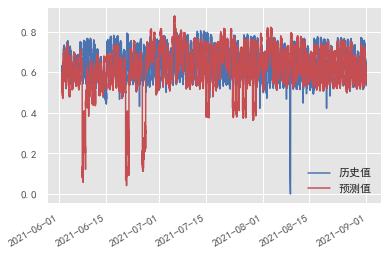

In [234]:
train1 = train0[len(train0)-a:len(train0)-b91][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y = train0[len(train0)-a:len(train0)-b91]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b91:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末','分']]
y_test1 = train0[len(train0)-b91:]['总有功功率（kw）']
model_lgb = lgb.LGBMRegressor(
                learning_rate=0.01,
                max_depth=-1,
                n_estimators=5000,
                    boosting_type='gbdt',
                    random_state=2021,
                    objective='regression',
                    num_leaves = '160',
                    verbose=-1)
lgb_model = model_lgb.fit(x_train1,y)
pred_test = model_lgb.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-b91:]['create_time'], train0[len(train0)-b91:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-b91:]['create_time'],pred_test , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\lgb3个月.jpg',dpi=400)
plt.show()

In [235]:
train1 = train0[len(train0)-a:len(train0)-b91][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
y = train0[len(train0)-a:len(train0)-b91]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b91:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
y_test1 = train0[len(train0)-b91:]['总有功功率（kw）']
catboost_model = CatBoostRegressor(
                            iterations=3500, learning_rate=0.01, depth=8,random_seed=2021,verbose = False
                                                        )


catboost_model2=catboost_model.fit(x_train1,y,verbose = False)

pred_test2 = catboost_model.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test2)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-b91:]['create_time'], train0[len(train0)-b91:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-b91:]['create_time'],pred_test2 , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\cat3个月.jpg',dpi=400)
plt.show()

MSE: 0.003567430320798586
RMSE: 0.059727969334295854
MAE: 0.041062219392850444
MAPE: inf
R方: 0.31418023653478633


In [236]:
train1 = train0[len(train0)-a:len(train0)-b91][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
y = train0[len(train0)-a:len(train0)-b91]['总有功功率（kw）']
x_train1 = train1
x_test1 = train0[len(train0)-b91:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
       'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '小时', '一年第几天',
       '一年第几周', '时间段', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
y_test1 = train0[len(train0)-b91:]['总有功功率（kw）']
xgb_model = xgb.XGBRegressor(
     objective='reg:squarederror',n_jobs=-1,n_estimators=5000,max_depth=7
                                            ,subsample=0.8,learning_rate= 0.08,gamma=0,colsample_bytree=0.9,
                                             random_state=10, max_features=None, alpha=0.9)
xgbboost_model1=xgb_model.fit(x_train1,y)
pred_test3 = xgb_model.predict(x_test1)
import numpy as np
from sklearn import metrics 
from sklearn.metrics import r2_score#R square
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array(y_test1)
y_pred = np.array(pred_test3)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cur = 1
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train0[len(train0)-b91:]['create_time'], train0[len(train0)-b91:]['总有功功率（kw）'],label='图例',color = 'b')
plt.plot(train0[len(train0)-b91:]['create_time'],pred_test3 , label='图例1',color = 'r')
plt.gcf().autofmt_xdate()
plt.legend(('历史值', '预测值')) 
plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\xgb未来3个月.jpg',dpi=400)
plt.show()

MSE: 0.006983373929579203
RMSE: 0.08356658380943427
MAE: 0.05304925051709572
MAPE: inf
R方: -0.3425170012854053


In [250]:
pred_test = (pred_test*pred_test2*pred_test3)**(1/3)
y_true = np.array(y_test1)
y_pred = np.array(pred_test)
print('MSE:',metrics.mean_squared_error(y_true, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
print('MAPE:',mape(y_true, y_pred))
print('R方:',r2_score(y_true, y_pred))

MSE: 0.005883286372124967
RMSE: 0.07670258386863488
MAE: 0.045823653660749405
MAPE: inf
R方: -0.13103093972291946


In [249]:
len(pred_test3)

8736

# 第二问预测

In [237]:
from datetime import datetime
df = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件2-行业日负荷数据.csv")
start = datetime(2018, 1, 1)
end = datetime(2021, 8, 31,23)
tm = pd.date_range(start, end, freq='D')#H表示小时hour
time=pd.to_datetime((tm)).strftime('%Y-%m-%d')
df = df.rename(columns={'数据时间':'日期'})
weather  = weather.drop_duplicates(subset='日期')
weather = weather.drop_duplicates(subset='日期').reset_index()
weather['日期'] = pd.DataFrame(time)
weather['日期'] = weather['日期'].astype('str')
df_max=pd.pivot_table(df,values='有功功率最大值（kw）',index='日期',columns='行业类型')
df_max = df.merge(weather,on='日期',how='left')
df_max.head()
df_max['日期'] = pd.to_datetime(df_max['日期'])
train0 = df_max.rename(columns={"日期":'create_time'})
train0['月'] = train0['create_time'].dt.month 
train0['天'] = train0['create_time'].dt.day
train0['小时'] = train0['create_time'].dt.hour
train0['一年第几天'] = train0['create_time'].dt.dayofyear
train0['一年第几周'] = train0['create_time'].dt.week

# test0['月'] = test0['create_time'].dt.month 
# test0['天'] = test0['create_time'].dt.day
# test0['小时'] = test0['create_time'].dt.hour
# test0['一年第几天'] = test0['create_time'].dt.dayofyear
# test0['一年第几周'] = test0['create_time'].dt.week
            
period_dict ={
            23: '深夜', 0: '深夜', 1: '深夜',
            2: '凌晨', 3: '凌晨', 4: '凌晨',
            5: '早晨', 6: '早晨', 7: '早晨',
            8: '上午', 9: '上午', 10: '上午', 11: '上午',
            12: '中午', 13: '中午',
            14: '下午', 15: '下午', 16: '下午', 17: '下午',
            18: '傍晚',
            19: '晚上', 20: '晚上', 21: '晚上', 22: '晚上',
            }
train0['时间段']=train0['小时'].map(period_dict)
dict1 = {'深夜':1, '凌晨':2, '早晨':3, '上午':4, '中午':5, '下午':6, '傍晚':7, '晚上':8}
train0['时间段'] = train0['时间段'].map(dict1)
            
# test0['时间段']=test0['小时'].map(period_dict)
        
# test0['时间段'] = test0['时间段'].map(dict1)
# 一年中的哪个季度
season_dict = {
                1: '春季', 2: '春季', 3: '春季',
                4: '夏季', 5: '夏季', 6: '夏季',
                7: '秋季', 8: '秋季', 9: '秋季',
                10: '冬季', 11: '冬季', 12: '冬季',
            }
train0['季节']=train0['月'].map(season_dict)
dict = {'春季':1,'夏季':2,'秋季':3,'冬季':4}
train0['季节'] = train0['季节'].map(dict)
# test0['季节']=test0['月'].map(season_dict)
# test0['季节'] = test0['季节'].map(dict)
            
train0['是否月初'] = train0['create_time'].apply(lambda x: x.is_month_start)
# 是否月末
train0['是否月末'] = train0['create_time'].apply(lambda x: x.is_month_end)
# 是否季节初
train0['是否季节初'] = train0['create_time'].apply(lambda x: x.is_quarter_start)
# 是否季节末
train0['是否季节末'] = train0['create_time'].apply(lambda x: x.is_quarter_end)
train0['是否周末'] = train0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

# test0['是否月初'] = test0['create_time'].apply(lambda x: x.is_month_start)
#                 # 是否月末
# test0['是否月末'] = test0['create_time'].apply(lambda x: x.is_month_end)
#                 # 是否季节初
# test0['是否季节初'] = test0['create_time'].apply(lambda x: x.is_quarter_start)
#                 # 是否季节末
# test0['是否季节末'] = test0['create_time'].apply(lambda x: x.is_quarter_end)
# test0['是否周末'] = test0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

train0['是否月末'] = [int(i) for i in train0['是否月末']]
train0['是否季节初'] = [int(i) for i in train0['是否季节初']]
train0['是否季节末'] = [int(i) for i in train0['是否季节末']]
train0['是否周末'] = [int(i) for i in train0['是否周末']]
train0['是否月初'] = [int(i) for i in train0['是否月初']]

#test0['是否月末'] = [int(i) for i in test0['是否月末']]
#test0['是否季节初'] = [int(i) for i in test0['是否季节初']]
#test0['是否季节末'] = [int(i) for i in test0['是否季节末']]
# test0['是否周末'] = [int(i) for i in test0['是否周末']]
#test0['是否月初'] = [int(i) for i in test0['是否月初']]

In [238]:
df_max=pd.pivot_table(df,values='有功功率最大值（kw）',index='日期',columns='行业类型')
df_max = df.merge(weather,on='日期',how='left')
df_max.head()

行业类型          日期  有功功率最大值（kw）  有功功率最小值（kw）  index   天气状况  最高温度  最低温度  \
0  大工业用电  2019-01-01  117888.3300   51526.5690    366    阴/阴    12     7   
1  大工业用电  2019-01-02  126843.7914   63638.4294    367  小雨/小雨    11     6   
2  大工业用电  2019-01-03  130286.1294  102048.2754    368  多云/小雨    15     9   
3  大工业用电  2019-01-04  133018.6344  104466.0762    369   阴/小雨    17    12   
4  大工业用电  2019-01-05  133504.4784   99507.3528    370   阴/小雨    17    12   

   白天风力风向  夜晚风力风向  start_weather  end_weather  温差  天气变化  
0       1       1              3            3   5     0  
1       1       1              5            5   5     0  
2       1       1              2            5   6    -3  
3       1       1              3            5   5    -2  
4       1       1              3            5   5    -2

In [239]:
df_max['日期'] = pd.to_datetime(df_max['日期'])

In [240]:
train0 = df_max.rename(columns={"日期":'create_time'})

In [241]:
train0['月'] = train0['create_time'].dt.month 
train0['天'] = train0['create_time'].dt.day
train0['小时'] = train0['create_time'].dt.hour
train0['一年第几天'] = train0['create_time'].dt.dayofyear
train0['一年第几周'] = train0['create_time'].dt.week

# test0['月'] = test0['create_time'].dt.month 
# test0['天'] = test0['create_time'].dt.day
# test0['小时'] = test0['create_time'].dt.hour
# test0['一年第几天'] = test0['create_time'].dt.dayofyear
# test0['一年第几周'] = test0['create_time'].dt.week
            
period_dict ={
            23: '深夜', 0: '深夜', 1: '深夜',
            2: '凌晨', 3: '凌晨', 4: '凌晨',
            5: '早晨', 6: '早晨', 7: '早晨',
            8: '上午', 9: '上午', 10: '上午', 11: '上午',
            12: '中午', 13: '中午',
            14: '下午', 15: '下午', 16: '下午', 17: '下午',
            18: '傍晚',
            19: '晚上', 20: '晚上', 21: '晚上', 22: '晚上',
            }
train0['时间段']=train0['小时'].map(period_dict)
dict1 = {'深夜':1, '凌晨':2, '早晨':3, '上午':4, '中午':5, '下午':6, '傍晚':7, '晚上':8}
train0['时间段'] = train0['时间段'].map(dict1)
            
# test0['时间段']=test0['小时'].map(period_dict)
        
# test0['时间段'] = test0['时间段'].map(dict1)
# 一年中的哪个季度
season_dict = {
                1: '春季', 2: '春季', 3: '春季',
                4: '夏季', 5: '夏季', 6: '夏季',
                7: '秋季', 8: '秋季', 9: '秋季',
                10: '冬季', 11: '冬季', 12: '冬季',
            }
train0['季节']=train0['月'].map(season_dict)
dict = {'春季':1,'夏季':2,'秋季':3,'冬季':4}
train0['季节'] = train0['季节'].map(dict)
# test0['季节']=test0['月'].map(season_dict)
# test0['季节'] = test0['季节'].map(dict)
            
train0['是否月初'] = train0['create_time'].apply(lambda x: x.is_month_start)
# 是否月末
train0['是否月末'] = train0['create_time'].apply(lambda x: x.is_month_end)
# 是否季节初
train0['是否季节初'] = train0['create_time'].apply(lambda x: x.is_quarter_start)
# 是否季节末
train0['是否季节末'] = train0['create_time'].apply(lambda x: x.is_quarter_end)
train0['是否周末'] = train0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

# test0['是否月初'] = test0['create_time'].apply(lambda x: x.is_month_start)
#                 # 是否月末
# test0['是否月末'] = test0['create_time'].apply(lambda x: x.is_month_end)
#                 # 是否季节初
# test0['是否季节初'] = test0['create_time'].apply(lambda x: x.is_quarter_start)
#                 # 是否季节末
# test0['是否季节末'] = test0['create_time'].apply(lambda x: x.is_quarter_end)
# test0['是否周末'] = test0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

train0['是否月末'] = [int(i) for i in train0['是否月末']]
train0['是否季节初'] = [int(i) for i in train0['是否季节初']]
train0['是否季节末'] = [int(i) for i in train0['是否季节末']]
train0['是否周末'] = [int(i) for i in train0['是否周末']]
train0['是否月初'] = [int(i) for i in train0['是否月初']]

#test0['是否月末'] = [int(i) for i in test0['是否月末']]
#test0['是否季节初'] = [int(i) for i in test0['是否季节初']]
#test0['是否季节末'] = [int(i) for i in test0['是否季节末']]
# test0['是否周末'] = [int(i) for i in test0['是否周末']]
#test0['是否月初'] = [int(i) for i in test0['是否月初']]

In [242]:
train0 

行业类型 create_time  有功功率最大值（kw）  有功功率最小值（kw）  index     天气状况  最高温度  最低温度  \
0     大工业用电  2019-01-01  117888.3300   51526.5690    366      阴/阴    12     7   
1     大工业用电  2019-01-02  126843.7914   63638.4294    367    小雨/小雨    11     6   
2     大工业用电  2019-01-03  130286.1294  102048.2754    368    多云/小雨    15     9   
3     大工业用电  2019-01-04  133018.6344  104466.0762    369     阴/小雨    17    12   
4     大工业用电  2019-01-05  133504.4784   99507.3528    370     阴/小雨    17    12   
...     ...         ...          ...          ...    ...      ...   ...   ...   
3605     商业  2021-08-27  104728.8762   19815.7638   1340  雷阵雨/雷阵雨    35    26   
3606     商业  2021-08-28   93855.1368   20820.2490   1341   雷阵雨/多云    33    26   
3607     商业  2021-08-29   84127.1658   21679.5828   1342  雷阵雨/雷阵雨    32    25   
3608     商业  2021-08-30  102851.2758   21036.5868   1343    阵雨/阵雨    34    26   
3609     商业  2021-08-31   96396.2568   21291.3042   1344   雷阵雨/阵雨    32    26   

      白天风力风向  夜晚风力风向  ...  小时  一年第几天  一年第几周  时间段  季节  是否月初  是否月末  是否季节初  \
0          1       1  ...   0      1      1    1   1     1     0      1   
1          1       1  ...   0      2      1    1   1     0     0      0   
2          1       1  ...   0      3      1    1   1     0     0      0   
3          1       1  ...   0      4      1    1   1     0     0      0   
4          1       1  ...   0      5      1    1   1     0     0      0   
...      ...     ...  ...  ..    ...    ...  ...  ..   ...   ...    ...   
3605       1       1  ...   0    239     34    1   3     0     0      0   
3606       1       1  ...   0    240     34    1   3     0     0      0   
3607       1       1  ...   0    241     34    1   3     0     0      0   
3608       1       1  ...   0    242     35    1   3     0     0      0   
3609       1       1  ...   0    243     35    1   3     0     1      0   

      是否季节末  是否周末  
0         0     0  
1         0     0  
2         0     0  
3         0     0  
4         0     1  
...     ...   ...  
3605      0     0  
3606      0     1  
3607      0     1  
3608      0     0  
3609      0     0  

[3610 rows x 26 columns]

In [243]:
train0 = train0[train0['行业类型']=='商业']

In [244]:
train0['有功功率最大值（kw）'] = (train0['有功功率最大值（kw）']-train0['有功功率最大值（kw）'].min())/(train0['有功功率最大值（kw）'].max()-train0['有功功率最大值（kw）'].min())
train0['有功功率最小值（kw）'] = (train0['有功功率最小值（kw）']-train0['有功功率最小值（kw）'].min())/(train0['有功功率最小值（kw）'].max()-train0['有功功率最小值（kw）'].min())

MSE: 0.03641703852850798
RMSE: 0.1908324881368683
MAE: 0.14537140703482018
MAPE: 11.613773526392364
R方: -1.6305661746036875


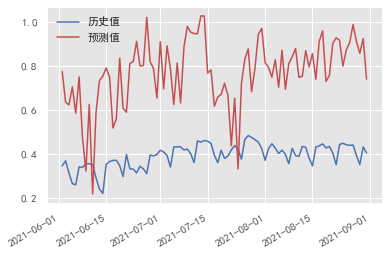

MSE: 0.05069812277221923
RMSE: 0.2251624364147342
MAE: 0.18082878499235405
MAPE: 1.0689822533751498
R方: -3.189978967495742


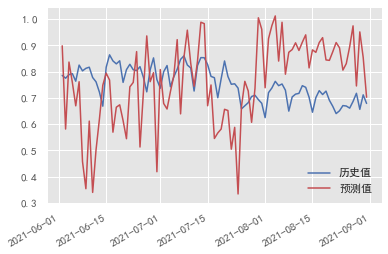

MSE: 0.028431014466498445
RMSE: 0.16861498885478254
MAE: 0.13036927387242359
MAPE: 0.20676201885728848
R方: -2.1298731614428603


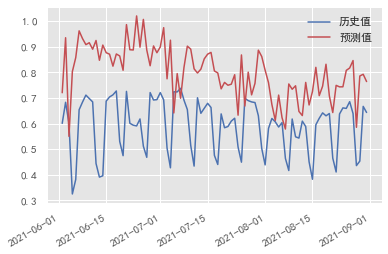

MSE: 0.06197776247248711
RMSE: 0.24895333392523009
MAE: 0.21309942880214586
MAPE: 2.767044407334027
R方: -4.89707374081235


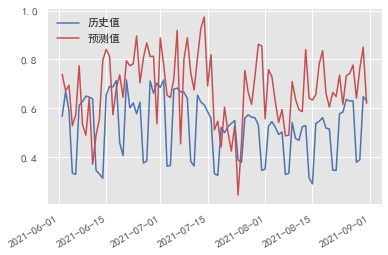

In [257]:
for i in ['商业','大工业用电','非普工业','普通工业']:
    
    from datetime import datetime
    df = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件2-行业日负荷数据.csv")
    start = datetime(2018, 1, 1)
    end = datetime(2021, 8, 31,23)
    tm = pd.date_range(start, end, freq='D')#H表示小时hour
    time=pd.to_datetime((tm)).strftime('%Y-%m-%d')
    df = df.rename(columns={'数据时间':'日期'})
#     weather  = weather.drop_duplicates(subset='日期')
#     weather = weather.drop_duplicates(subset='日期').reset_index()
#     weather['日期'] = pd.DataFrame(time)
#     weather['日期'] = weather['日期'].astype('str')
    df_max=pd.pivot_table(df,values='有功功率最小值（kw）',index='日期',columns='行业类型')
    df_max = df.merge(weather,on='日期',how='left')
    df_max.head()
    df_max['日期'] = pd.to_datetime(df_max['日期'])
    train0 = df_max.rename(columns={"日期":'create_time'})
    train0['月'] = train0['create_time'].dt.month 
    train0['天'] = train0['create_time'].dt.day
    train0['小时'] = train0['create_time'].dt.hour
    train0['一年第几天'] = train0['create_time'].dt.dayofyear
    train0['一年第几周'] = train0['create_time'].dt.week

    # test0['月'] = test0['create_time'].dt.month 
    # test0['天'] = test0['create_time'].dt.day
    # test0['小时'] = test0['create_time'].dt.hour
    # test0['一年第几天'] = test0['create_time'].dt.dayofyear
    # test0['一年第几周'] = test0['create_time'].dt.week

    period_dict ={
                23: '深夜', 0: '深夜', 1: '深夜',
                2: '凌晨', 3: '凌晨', 4: '凌晨',
                5: '早晨', 6: '早晨', 7: '早晨',
                8: '上午', 9: '上午', 10: '上午', 11: '上午',
                12: '中午', 13: '中午',
                14: '下午', 15: '下午', 16: '下午', 17: '下午',
                18: '傍晚',
                19: '晚上', 20: '晚上', 21: '晚上', 22: '晚上',
                }
    train0['时间段']=train0['小时'].map(period_dict)
    dict1 = {'深夜':1, '凌晨':2, '早晨':3, '上午':4, '中午':5, '下午':6, '傍晚':7, '晚上':8}
    train0['时间段'] = train0['时间段'].map(dict1)

    # test0['时间段']=test0['小时'].map(period_dict)

    # test0['时间段'] = test0['时间段'].map(dict1)
    # 一年中的哪个季度
    season_dict = {
                    1: '春季', 2: '春季', 3: '春季',
                    4: '夏季', 5: '夏季', 6: '夏季',
                    7: '秋季', 8: '秋季', 9: '秋季',
                    10: '冬季', 11: '冬季', 12: '冬季',
                }
    train0['季节']=train0['月'].map(season_dict)
    dict = {'春季':1,'夏季':2,'秋季':3,'冬季':4}
    train0['季节'] = train0['季节'].map(dict)
    # test0['季节']=test0['月'].map(season_dict)
    # test0['季节'] = test0['季节'].map(dict)

    train0['是否月初'] = train0['create_time'].apply(lambda x: x.is_month_start)
    # 是否月末
    train0['是否月末'] = train0['create_time'].apply(lambda x: x.is_month_end)
    # 是否季节初
    train0['是否季节初'] = train0['create_time'].apply(lambda x: x.is_quarter_start)
    # 是否季节末
    train0['是否季节末'] = train0['create_time'].apply(lambda x: x.is_quarter_end)
    train0['是否周末'] = train0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

    # test0['是否月初'] = test0['create_time'].apply(lambda x: x.is_month_start)
    #                 # 是否月末
    # test0['是否月末'] = test0['create_time'].apply(lambda x: x.is_month_end)
    #                 # 是否季节初
    # test0['是否季节初'] = test0['create_time'].apply(lambda x: x.is_quarter_start)
    #                 # 是否季节末
    # test0['是否季节末'] = test0['create_time'].apply(lambda x: x.is_quarter_end)
    # test0['是否周末'] = test0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

    train0['是否月末'] = [int(i) for i in train0['是否月末']]
    train0['是否季节初'] = [int(i) for i in train0['是否季节初']]
    train0['是否季节末'] = [int(i) for i in train0['是否季节末']]
    train0['是否周末'] = [int(i) for i in train0['是否周末']]
    train0['是否月初'] = [int(i) for i in train0['是否月初']]

    #test0['是否月末'] = [int(i) for i in test0['是否月末']]
    #test0['是否季节初'] = [int(i) for i in test0['是否季节初']]
    #test0['是否季节末'] = [int(i) for i in test0['是否季节末']]
    # test0['是否周末'] = [int(i) for i in test0['是否周末']]
    #test0['是否月初'] = [int(i) for i in test0['是否月初']]
    train0 = train0[train0['行业类型']==i]
    train0['有功功率最大值（kw）'] = (train0['有功功率最大值（kw）']-train0['有功功率最大值（kw）'].min())/(train0['有功功率最大值（kw）'].max()-train0['有功功率最大值（kw）'].min())
    train0['有功功率最小值（kw）'] = (train0['有功功率最小值（kw）']-train0['有功功率最小值（kw）'].min())/(train0['有功功率最小值（kw）'].max()-train0['有功功率最小值（kw）'].min())
    train1 = train0[:len(train0)-91][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
           'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '一年第几天',
           '一年第几周','季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
    y = train0[:len(train0)-91]['有功功率最小值（kw）']
    x_train1 = train1
    x_test1 = train0[len(train0)-91:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
           'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '一年第几天',
           '一年第几周', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
    y_test1 = train0[len(train0)-91:]['有功功率最小值（kw）']
    model_lgb = lgb.LGBMRegressor(
                    learning_rate=0.01,
                    max_depth=6,
                    n_estimators=5000,
                        boosting_type='gbdt',
                        random_state=2021,
                        objective='regression',
                        num_leaves = '36',#256  #'32'线上4.10
                        verbose=-1)
    lgb_model = model_lgb.fit(x_train1,y)
    pred_test1 = model_lgb.predict(x_test1)
    import numpy as np
    from sklearn import metrics 
    from sklearn.metrics import r2_score#R square
    # MAPE需要自己实现
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_pred - y_true) / y_true))
    y_true = np.array(y_test1)
    y_pred = np.array(pred_test1)
    print('MSE:',metrics.mean_squared_error(y_true, y_pred))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
    print('MAPE:',mape(y_true, y_pred))
    print('R方:',r2_score(y_true, y_pred))
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    cur = 1
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.plot(train0[len(train0)-91:]['create_time'], train0[len(train0)-91:]['有功功率最大值（kw）'],label='图例',color = 'b')
    plt.plot(train0[len(train0)-91:]['create_time'],pred_test1 , label='图例1',color = 'r')
    plt.gcf().autofmt_xdate()
    plt.legend(('历史值', '预测值')) 
    plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\第二大问lgb(%s).jpg'%i,dpi=400)
    plt.show()

MSE: 0.039836608903376106
RMSE: 0.19959110426914348
MAE: 0.17397732795335075
MAPE: 0.4500305550224034
R方: -12.702584679323609


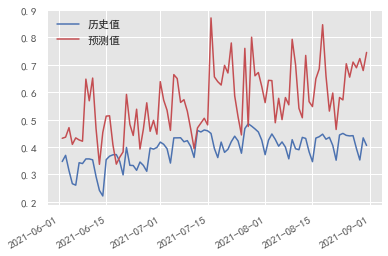

MSE: 0.019618919938110508
RMSE: 0.1400675549087315
MAE: 0.11626494555674131
MAPE: 0.16239539500793893
R方: -4.0625429347196915


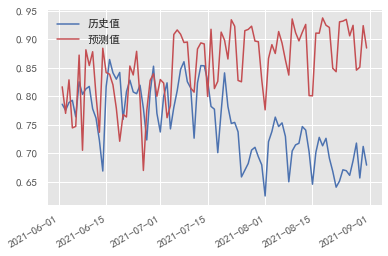

MSE: 0.01918427567660882
RMSE: 0.13850731271889158
MAE: 0.12586029115259936
MAPE: 0.22493990760644597
R方: -0.747586530537717


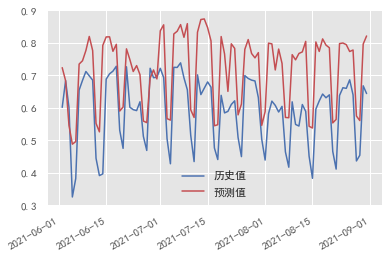

MSE: 0.025460689119777464
RMSE: 0.15956405961173545
MAE: 0.14693638997527733
MAPE: 0.3011273768975631
R方: -0.6164213444581346


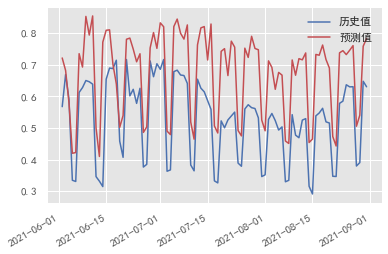

In [255]:
for i in ['商业','大工业用电','非普工业','普通工业']:
    
    from datetime import datetime
    df = pd.read_csv(r"C:\Users\18484\Desktop\全部数据\附件2-行业日负荷数据.csv")
    start = datetime(2018, 1, 1)
    end = datetime(2021, 8, 31,23)
    tm = pd.date_range(start, end, freq='D')#H表示小时hour
    time=pd.to_datetime((tm)).strftime('%Y-%m-%d')
    df = df.rename(columns={'数据时间':'日期'})
#     weather  = weather.drop_duplicates(subset='日期')
#     weather = weather.drop_duplicates(subset='日期').reset_index()
#     weather['日期'] = pd.DataFrame(time)
#     weather['日期'] = weather['日期'].astype('str')
    df_max=pd.pivot_table(df,values='有功功率最大值（kw）',index='日期',columns='行业类型')
    df_max = df.merge(weather,on='日期',how='left')
    df_max.head()
    df_max['日期'] = pd.to_datetime(df_max['日期'])
    train0 = df_max.rename(columns={"日期":'create_time'})
    train0['月'] = train0['create_time'].dt.month 
    train0['天'] = train0['create_time'].dt.day
    train0['小时'] = train0['create_time'].dt.hour
    train0['一年第几天'] = train0['create_time'].dt.dayofyear
    train0['一年第几周'] = train0['create_time'].dt.week

    # test0['月'] = test0['create_time'].dt.month 
    # test0['天'] = test0['create_time'].dt.day
    # test0['小时'] = test0['create_time'].dt.hour
    # test0['一年第几天'] = test0['create_time'].dt.dayofyear
    # test0['一年第几周'] = test0['create_time'].dt.week

    period_dict ={
                23: '深夜', 0: '深夜', 1: '深夜',
                2: '凌晨', 3: '凌晨', 4: '凌晨',
                5: '早晨', 6: '早晨', 7: '早晨',
                8: '上午', 9: '上午', 10: '上午', 11: '上午',
                12: '中午', 13: '中午',
                14: '下午', 15: '下午', 16: '下午', 17: '下午',
                18: '傍晚',
                19: '晚上', 20: '晚上', 21: '晚上', 22: '晚上',
                }
    train0['时间段']=train0['小时'].map(period_dict)
    dict1 = {'深夜':1, '凌晨':2, '早晨':3, '上午':4, '中午':5, '下午':6, '傍晚':7, '晚上':8}
    train0['时间段'] = train0['时间段'].map(dict1)

    # test0['时间段']=test0['小时'].map(period_dict)

    # test0['时间段'] = test0['时间段'].map(dict1)
    # 一年中的哪个季度
    season_dict = {
                    1: '春季', 2: '春季', 3: '春季',
                    4: '夏季', 5: '夏季', 6: '夏季',
                    7: '秋季', 8: '秋季', 9: '秋季',
                    10: '冬季', 11: '冬季', 12: '冬季',
                }
    train0['季节']=train0['月'].map(season_dict)
    dict = {'春季':1,'夏季':2,'秋季':3,'冬季':4}
    train0['季节'] = train0['季节'].map(dict)
    # test0['季节']=test0['月'].map(season_dict)
    # test0['季节'] = test0['季节'].map(dict)

    train0['是否月初'] = train0['create_time'].apply(lambda x: x.is_month_start)
    # 是否月末
    train0['是否月末'] = train0['create_time'].apply(lambda x: x.is_month_end)
    # 是否季节初
    train0['是否季节初'] = train0['create_time'].apply(lambda x: x.is_quarter_start)
    # 是否季节末
    train0['是否季节末'] = train0['create_time'].apply(lambda x: x.is_quarter_end)
    train0['是否周末'] = train0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

    # test0['是否月初'] = test0['create_time'].apply(lambda x: x.is_month_start)
    #                 # 是否月末
    # test0['是否月末'] = test0['create_time'].apply(lambda x: x.is_month_end)
    #                 # 是否季节初
    # test0['是否季节初'] = test0['create_time'].apply(lambda x: x.is_quarter_start)
    #                 # 是否季节末
    # test0['是否季节末'] = test0['create_time'].apply(lambda x: x.is_quarter_end)
    # test0['是否周末'] = test0['create_time'].apply(lambda x: True if x.dayofweek in [5, 6] else False)

    train0['是否月末'] = [int(i) for i in train0['是否月末']]
    train0['是否季节初'] = [int(i) for i in train0['是否季节初']]
    train0['是否季节末'] = [int(i) for i in train0['是否季节末']]
    train0['是否周末'] = [int(i) for i in train0['是否周末']]
    train0['是否月初'] = [int(i) for i in train0['是否月初']]

    #test0['是否月末'] = [int(i) for i in test0['是否月末']]
    #test0['是否季节初'] = [int(i) for i in test0['是否季节初']]
    #test0['是否季节末'] = [int(i) for i in test0['是否季节末']]
    # test0['是否周末'] = [int(i) for i in test0['是否周末']]
    #test0['是否月初'] = [int(i) for i in test0['是否月初']]
    train0 = train0[train0['行业类型']==i]
    train0['有功功率最大值（kw）'] = (train0['有功功率最大值（kw）']-train0['有功功率最大值（kw）'].min())/(train0['有功功率最大值（kw）'].max()-train0['有功功率最大值（kw）'].min())
    train0['有功功率最小值（kw）'] = (train0['有功功率最小值（kw）']-train0['有功功率最小值（kw）'].min())/(train0['有功功率最小值（kw）'].max()-train0['有功功率最小值（kw）'].min())
    train1 = train0[:len(train0)-91][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
           'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '一年第几天',
           '一年第几周','季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
    y = train0[:len(train0)-91]['有功功率最大值（kw）']
    x_train1 = train1
    x_test1 = train0[len(train0)-91:][[ '最高温度', '最低温度', '白天风力风向', '夜晚风力风向',
           'start_weather', 'end_weather', '温差', '天气变化', '月', '天', '一年第几天',
           '一年第几周', '季节', '是否月初', '是否月末', '是否季节初', '是否季节末', '是否周末']]
    y_test1 = train0[len(train0)-91:]['有功功率最大值（kw）']
    catboost_model = CatBoostRegressor(
                                iterations=3500, learning_rate=0.01, depth=8,random_seed=2021,verbose = False
                                                            )


    catboost_model2=catboost_model.fit(x_train1,y,verbose = False)

    pred_test1 = catboost_model.predict(x_test1)
    import numpy as np
    from sklearn import metrics 
    from sklearn.metrics import r2_score#R square
    # MAPE需要自己实现
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_pred - y_true) / y_true))
    y_true = np.array(y_test1)
    y_pred = np.array(pred_test1)
    print('MSE:',metrics.mean_squared_error(y_true, y_pred))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('MAE:',metrics.mean_absolute_error(y_true, y_pred))
    print('MAPE:',mape(y_true, y_pred))
    print('R方:',r2_score(y_true, y_pred))
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    cur = 1
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.plot(train0[len(train0)-91:]['create_time'], train0[len(train0)-91:]['有功功率最大值（kw）'],label='图例',color = 'b')
    plt.plot(train0[len(train0)-91:]['create_time'],pred_test1 , label='图例1',color = 'r')
    plt.gcf().autofmt_xdate()
    plt.legend(('历史值', '预测值')) 
    plt.savefig(r'C:\Users\18484\Desktop\机器学习精度\第二大问cat(%s).jpg'%i,dpi=400)
    plt.show()